#Import Libraries

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

#Install the Kaggle API

In [ ]:
!pip install kaggle


#Upload the kaggle.json file

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"moeedabbasi","key":"eaff3badf706da18e85358398e34740e"}'}

#Setup Kaggle API Credentials

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#Download the Kvasir Dataset

In [ ]:
!kaggle datasets download -d abdallahwagih/kvasir-dataset-for-classification-and-segmentation

Dataset URL: https://www.kaggle.com/datasets/abdallahwagih/kvasir-dataset-for-classification-and-segmentation
License(s): CC0-1.0
100% 1.19G/1.20G [01:03<00:00, 21.2MB/s]
100% 1.20G/1.20G [01:03<00:00, 20.4MB/s]


#Unzipping the dataset

In [ ]:
!unzip kvasir-dataset-for-classification-and-segmentation.zip -d ./kvasir_data

Streaming output truncated to the last 5000 lines.
  inflating: ./kvasir_data/kvasir-dataset/kvasir-dataset/esophagitis/00687a70-bbad-4bf9-864f-9f7b3c27a2c8.jpg  
  inflating: ./kvasir_data/kvasir-dataset/kvasir-dataset/esophagitis/0134d93d-0922-4063-9acd-a4177f2b0c07.jpg  
  inflating: ./kvasir_data/kvasir-dataset/kvasir-dataset/esophagitis/01a57b1a-780f-4e52-9f94-291c2982154d.jpg  
  inflating: ./kvasir_data/kvasir-dataset/kvasir-dataset/esophagitis/01f092a2-fccb-49f6-af06-8351c8bb47f1.jpg  
  inflating: ./kvasir_data/kvasir-dataset/kvasir-dataset/esophagitis/022b40a7-a36f-4510-95a1-b6bb709e94ed.jpg  
  inflating: ./kvasir_data/kvasir-dataset/kvasir-dataset/esophagitis/02b1d319-dea6-418b-969a-c588585cb4f2.jpg  
  inflating: ./kvasir_data/kvasir-dataset/kvasir-dataset/esophagitis/02de4b4c-8704-45f7-b90f-6004d76bdded.jpg  
  inflating: ./kvasir_data/kvasir-dataset/kvasir-dataset/esophagitis/0339a2f7-65bb-41fb-8650-e119670b4e2e.jpg  
  inflating: ./kvasir_data/kvasir-dataset/kvasir-data

#List the Contents

In [ ]:
import os
dataset_dir = './kvasir_data'
print(os.listdir(dataset_dir))

['kvasir-dataset', 'kvasir-seg']


#Set the Paths to Images and Masks

In [ ]:
image_dir = './kvasir_data/kvasir-seg/Kvasir-SEG/images'
mask_dir = './kvasir_data/kvasir-seg/Kvasir-SEG/masks'

# Load images and masks into arrays

In [ ]:
def load_data(image_dir, mask_dir, img_size=(256, 256)):
    images = sorted([os.path.join(image_dir, img) for img in os.listdir(image_dir)])
    masks = sorted([os.path.join(mask_dir, msk) for msk in os.listdir(mask_dir)])

    X = []
    Y = []
    for img_path, mask_path in zip(images, masks):
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        mask = np.expand_dims(mask, axis=-1)

        X.append(img)
        Y.append(mask)

    X = np.array(X)
    Y = np.array(Y) / 255.0  # Normalize masks to [0, 1]

    return X, Y

X, Y = load_data(image_dir, mask_dir)

# Split into training and validation sets

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")

Training samples: 800, Validation samples: 200


# UNet Model

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model


#loss function,optimizer and summary

In [ ]:
model = unet_model(input_size=(256, 256, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 32, 32, 1024)   │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1536)   │              0 │ up_sampling2d[0][0],   │
│                      

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

#Model Training

In [ ]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=16)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.6994 - loss: 100.2286 - val_accuracy: 0.8177 - val_loss: 0.4871
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 87s 853ms/step - accuracy: 0.8387 - loss: 0.4567 - val_accuracy: 0.8237 - val_loss: 0.4606
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 821ms/step - accuracy: 0.8444 - loss: 0.4359 - val_accuracy: 0.8334 - val_loss: 0.4493
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 854ms/step - accuracy: 0.8393 - loss: 0.4429 - val_accuracy: 0.8335 - val_loss: 0.4419
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 846ms/step - accuracy: 0.8366 - loss: 0.4536 - val_accuracy: 0.8336 - val_loss: 0.4309
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 848ms/step - accuracy: 0.8439 - loss: 0.4239 - val_accuracy: 0.8063 - val_loss: 0.4677
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 846ms/step - accuracy: 0.8463 - loss: 0.4286 - val_accuracy: 0.8337 - val_loss: 0.3949
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 817ms/step - accuracy: 0.8410 - loss: 0.3722 - val_accu

# Model Evaluation

In [ ]:
loss, accuracy = model.evaluate(X_val, Y_val)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')


7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 357ms/step - accuracy: 0.8276 - loss: 0.4024
Validation Loss: 0.3848339021205902, Validation Accuracy: 0.8335672616958618


#Visualize Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


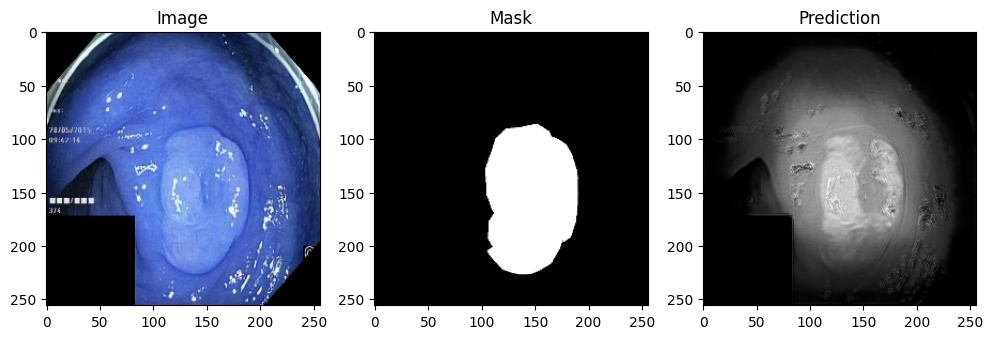

In [ ]:
import matplotlib.pyplot as plt

def plot_sample(image, mask, prediction):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.title('Mask')
    plt.imshow(mask, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(prediction, cmap='gray')
    plt.show()

sample_image = X_val[0]
sample_mask = Y_val[0]
prediction = model.predict(np.expand_dims(sample_image, axis=0))[0]
plot_sample(sample_image, sample_mask, prediction)


#Install Accelerate Library

In [ ]:
!pip install accelerate

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

#Install Diffusers Library

In [ ]:
pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 67.4 MB/s eta 0:00:00


#Install Transformers Library

In [ ]:
pip install transformers

#Load Stable Diffusion Inpainting Pipeline

In [ ]:
from diffusers import StableDiffusionInpaintPipeline
import torch
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
).to('cuda')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:219: FutureWarning: You are loading the variant fp16 from runwayml/stable-diffusion-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
vae/diffusion_pytorch_model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.75k [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/810 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/821 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/afeee10def38be19995784bcc811882409d066e5/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/afeee10def38be19995784bcc811882409d066e5/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/afeee10def38be19995784bcc811882409d066e5/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/afeee10def38be19995784bcc811882409d066e5/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/f

In [ ]:
print(pil_image1.size)

(622, 529)


#Load and Display Images with PIL

In [ ]:
from PIL import Image
image1_path = 'orig5.jpg'
image2_path = 'mask5.jpg'
pil_image1 = Image.open(image1_path)
pil_image2 = Image.open(image2_path)
pil_image1.show()  # This will open the image in the default image viewer
pil_image2.show()

#Generate Inpainted Image with Custom Prompt

In [ ]:
prompt = "Remove bump, Remove polyp, Remove Tumor, Clean Polyp, Clean Bump, No Polyp, No tumor, No bump"

image = pipe(prompt=prompt, image=pil_image1,  mask_image=pil_image2, guidance_scale =15,height = 640, width =640 , num_inference_steps = 20).images[0]
image

  0%|          | 0/20 [00:00<?, ?it/s]

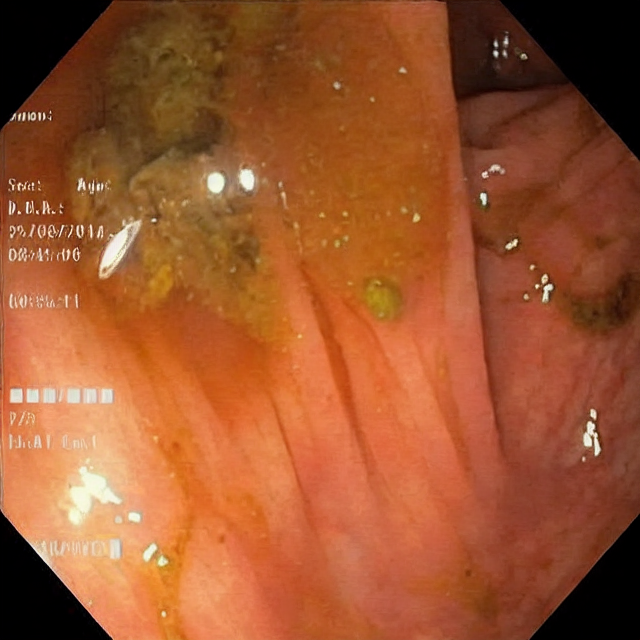

In [ ]:
prompt = "Remove bump, Remove polyp, Remove Tumor, Clean Polyp, Clean Bump, No Polyp, No tumor, No bump, Clean background"

image = pipe(prompt=prompt, image=pil_image1,  mask_image=pil_image2, guidance_scale =15,height = 640, width =640 , num_inference_steps = 20).images[0]
image